In [1]:
!pip install -q tabulate

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# Exploratory Data Analysis (EDA)

## Data Quality and Consistency Check

To ensure the dataset is reliable for analysis, we check for:
- Check for Duplicates
- Features(Numeric and Categorical)
- Inconsistency in data
- Correlations among numerical features
- Overall feature consistency and anomalies

In [2]:
cars = pd.read_csv("project_data/train.csv")
print("Data shape:", cars.shape)
cars.info()
cars.head()

Data shape: (75973, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


## Removing Duplicates

In [3]:
cars.set_index('carID', inplace=True)
cars = cars.drop_duplicates().reset_index()

## Statistical Analysis of the data

In [4]:
cars.drop(columns=['carID']).describe()

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,74478.000000,75969.000000,74507.000000,68067.000000,68045.000000,74453.000000,74445.000000,74419.000000,74421.0
mean,2017.096576,16882.001922,23004.761128,120.328500,55.152286,1.660161,64.591773,1.994485,0.0
std,2.208750,9737.075658,22130.041696,65.522046,16.497834,0.573464,21.020975,1.472961,0.0
min,1970.000000,450.000000,-58540.574478,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,2016.000000,10200.000000,7423.500000,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,2017.000000,14699.000000,17301.000000,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,2019.000000,20950.000000,32428.000000,145.000000,62.800000,2.000000,82.000000,3.000000,0.0
max,2024.121759,159999.000000,323000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


## Check Features(Numerical & Categorical)

In [5]:
num_cols = cars.select_dtypes(include=[np.number]).drop(columns=['carID']).columns.tolist()
cat_cols = cars.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
Categorical columns: ['Brand', 'model', 'transmission', 'fuelType']


## Data Inconsistency Check
- Impossible Year Check(Since data is till 2020, year with 2024 should not exist)
- Checking of Zero's(0's) in data, Since previousOwners, hasDamage(Boolean) & Tax can be zero, A consistency check is mandatory on rest
- Missing Values in Numerical & Categorical Columns along with Percentage of data which is missing

### Impossible Year Check

In [6]:
impossible_years = cars[cars['year'] > 2020]
print(f"Number of cars with year > 2020: {len(impossible_years)}")

Number of cars with year > 2020: 358


### Check for Zero values in Numerical Columns

In [7]:
num_cols = cars.select_dtypes(include=[np.number]).columns.tolist()
valid_zero_cols = ['previousOwners', 'hasDamage', 'tax']
invalid_summary = []

for col in num_cols:
    zero_count = (cars[col] == 0).sum()
    neg_count = (cars[col] < 0).sum()
    perc_zero = (cars[col] == 0).mean() * 100
    perc_neg = (cars[col] < 0).mean() * 100

    if zero_count > 0 or neg_count > 0:
        invalid_summary.append((col, zero_count, neg_count, perc_zero, perc_neg))

if invalid_summary:
    invalid_df = pd.DataFrame(
        invalid_summary,
        columns=["Column", "Zero Count", "Negative Count", "% Zero", "% Negative"]
    )

    print("Columns with Negative Values:\n")
    display(invalid_df[invalid_df["Negative Count"] > 0])
else:
    print("No zero or negative values found in numeric columns.")

Columns with Negative Values:



,Column,Zero Count,Negative Count,% Zero,% Negative
1,mileage,0,369,0.000000,0.485724
2,tax,4320,378,5.686530,0.497571
3,mpg,0,36,0.000000,0.047388
4,engineSize,180,84,0.236939,0.110571
5,previousOwners,14879,371,19.585620,0.488357


### Missing Values check

Missing Values in Categorical Columns:



,Missing Count
transmission,1522
Brand,1521
model,1517
fuelType,1511


Missing Values in Categorical Columns:



,Missing Count,Missing %
transmission,1522,2.003449
Brand,1521,2.002132
model,1517,1.996867
fuelType,1511,1.988969


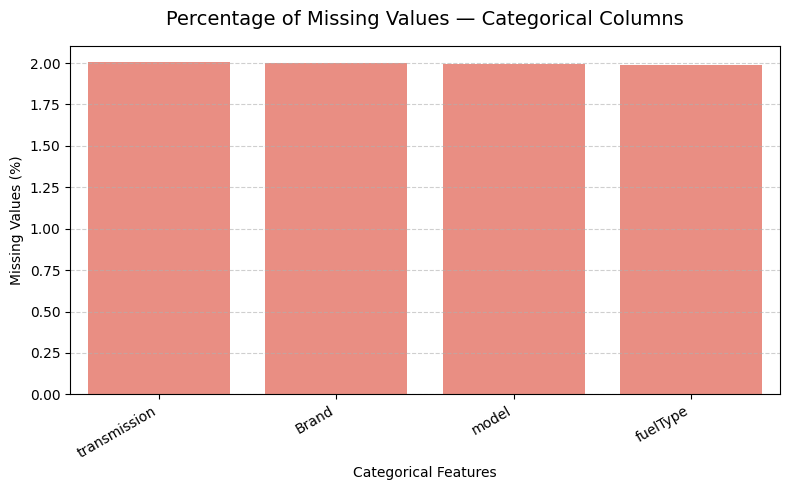

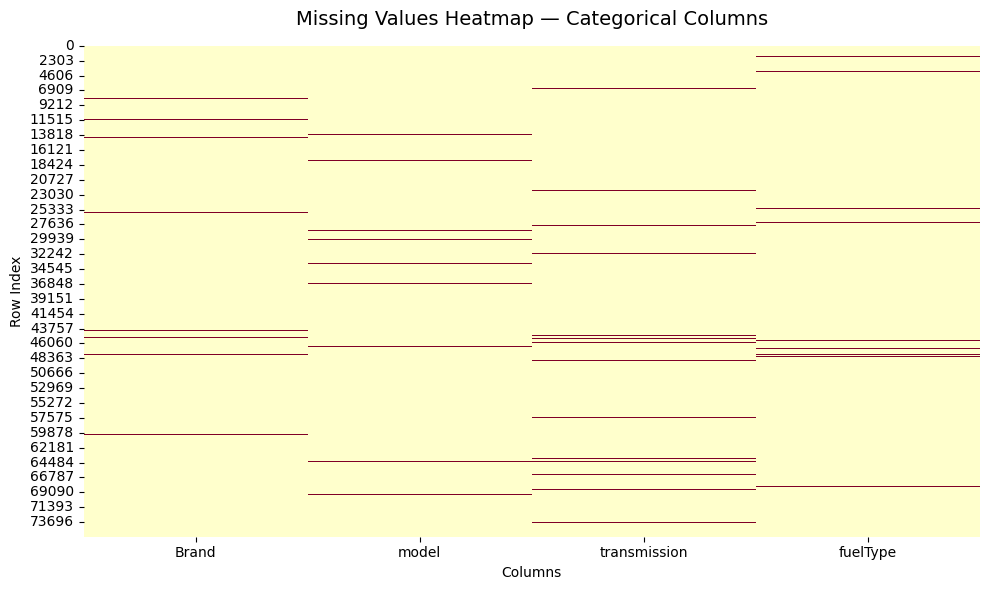

In [8]:
missing_cats = (
    cars[cat_cols]
    .apply(lambda x: x.isna() | x.astype(str).str.strip().isin(["", "nan", "none", "null", "NaN", "None"]))
    .sum()
)
missing_cats = missing_cats[missing_cats > 0].sort_values(ascending=False)

print("Missing Values in Categorical Columns:\n")
display(missing_cats.to_frame("Missing Count"))

missing_counts = cars[cat_cols].isna().sum()
missing_percent = (missing_counts / len(cars)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
}).sort_values(by='Missing Count', ascending=False)
missing_df = missing_df[missing_df['Missing Count'] > 0]

print("Missing Values in Categorical Columns:\n")
display(missing_df)

plt.figure(figsize=(8, 5))
sns.barplot(x=missing_df.index, y=missing_df['Missing %'], color='salmon')
plt.title("Percentage of Missing Values — Categorical Columns", fontsize=14, pad=15)
plt.ylabel("Missing Values (%)")
plt.xlabel("Categorical Features")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(cars[cat_cols].isna(), cbar=False, cmap="YlOrRd")
plt.title("Missing Values Heatmap — Categorical Columns", fontsize=14, pad=15)
plt.xlabel("Columns")
plt.ylabel("Row Index")
plt.tight_layout()
plt.show()

,Missing Count,Missing %
mpg,7924,10.430570
tax,7902,10.401611
previousOwners,1550,2.040306
hasDamage,1548,2.037673
paintQuality%,1524,2.006081
engineSize,1516,1.995551
year,1491,1.962643
mileage,1462,1.924469


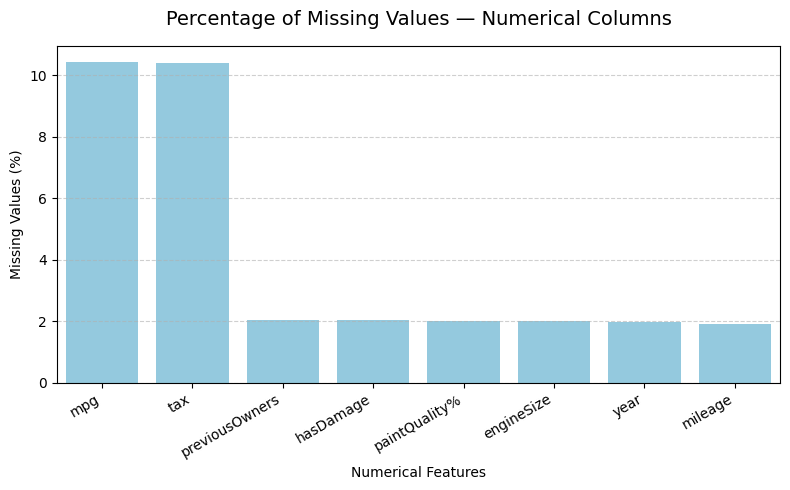

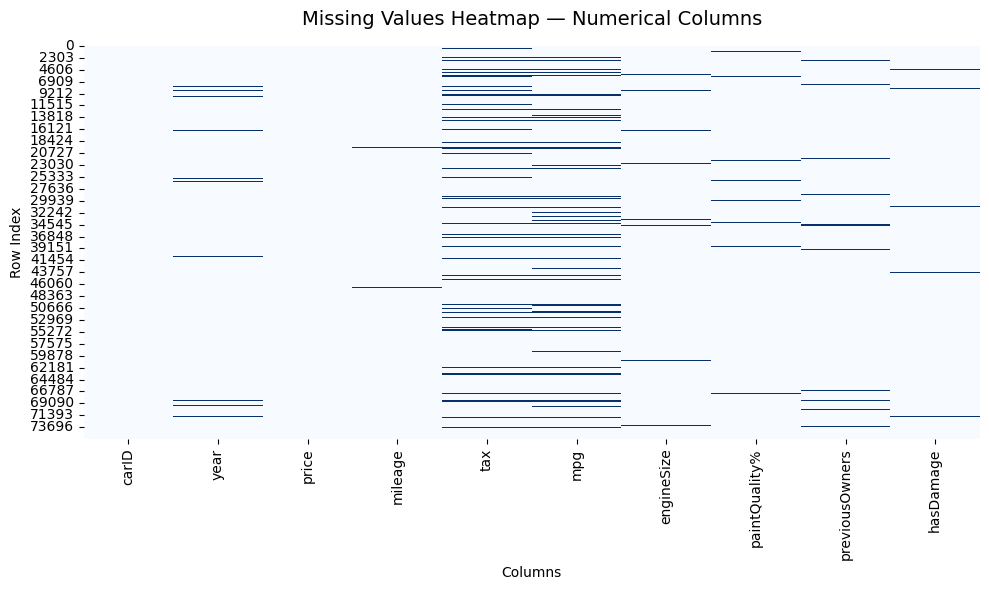

In [9]:
missing_counts = cars[num_cols].isna().sum()
missing_percent = (missing_counts / len(cars)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
}).sort_values(by='Missing Count', ascending=False)
missing_df = missing_df[missing_df['Missing Count'] > 0]

display(missing_df)

plt.figure(figsize=(8, 5))
sns.barplot(x=missing_df.index, y=missing_df['Missing %'], color='skyblue')
plt.title("Percentage of Missing Values — Numerical Columns", fontsize=14, pad=15)
plt.ylabel("Missing Values (%)")
plt.xlabel("Numerical Features")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(cars[num_cols].isna(), cbar=False, cmap="Blues")
plt.title("Missing Values Heatmap — Numerical Columns", fontsize=14, pad=15)
plt.xlabel("Columns")
plt.ylabel("Row Index")
plt.tight_layout()
plt.show()


## Missing Values Summary

In [10]:
print("\nMissing Value Summary:")
missing = cars.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) == 0:
    print(" No missing values detected!")
else:
    display(missing.to_frame("Missing Count"))


Missing Value Summary:


,Missing Count
mpg,7924
tax,7902
previousOwners,1550
hasDamage,1548
paintQuality%,1524
transmission,1522
Brand,1521
model,1517
engineSize,1516
fuelType,1511


## Visual Data Exploration and Preliminary Findings

Numeric columns (10): ['carID', 'year', 'price', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
Categorical columns (4): ['Brand', 'model', 'transmission', 'fuelType']

 Numeric Feature Distributions


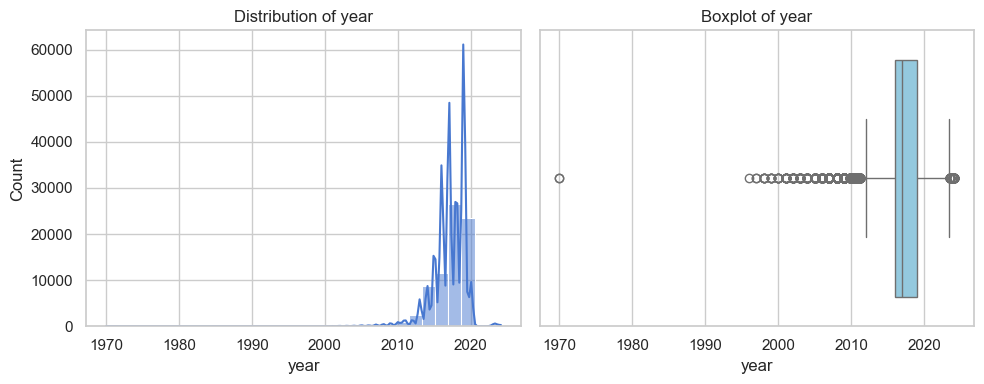

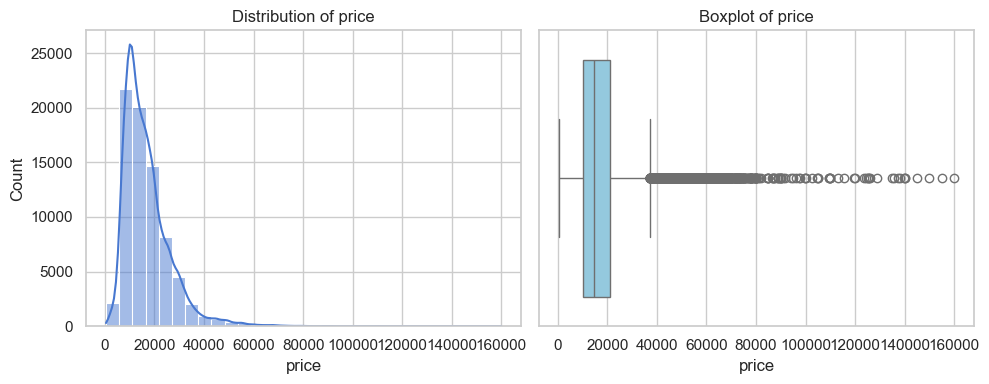

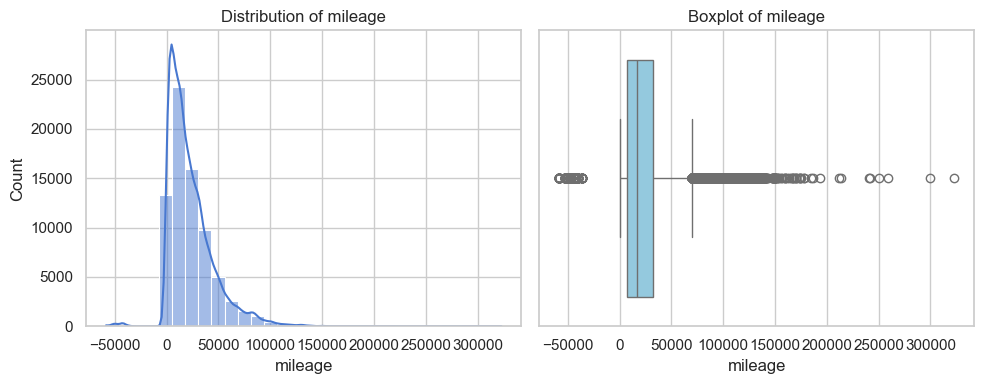

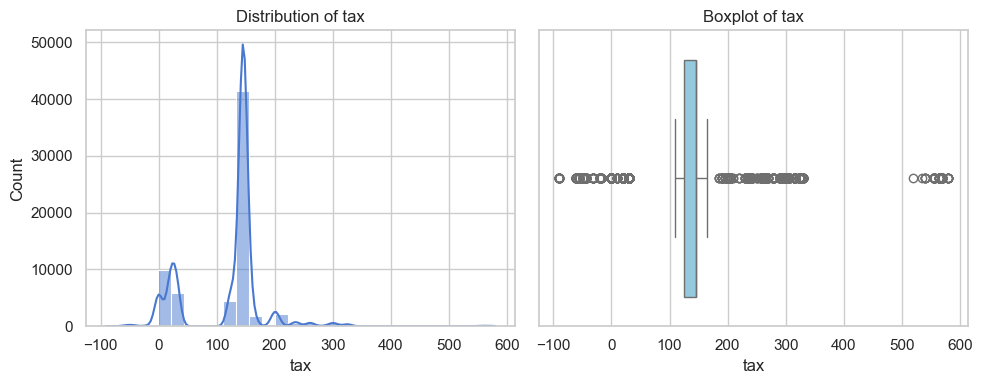

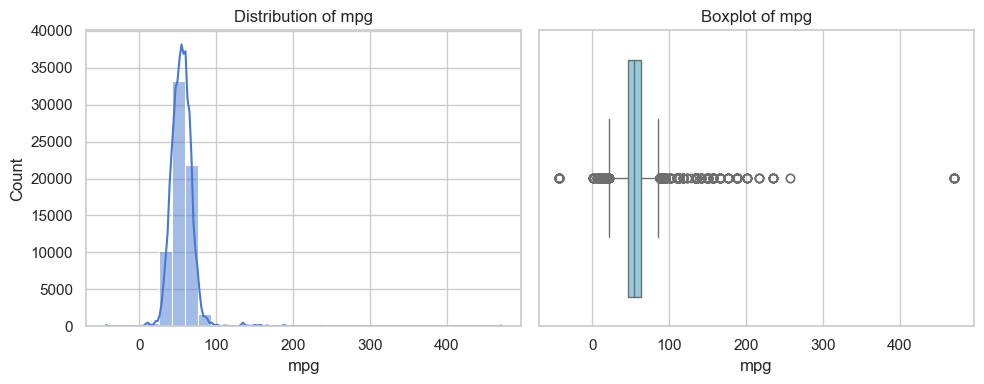

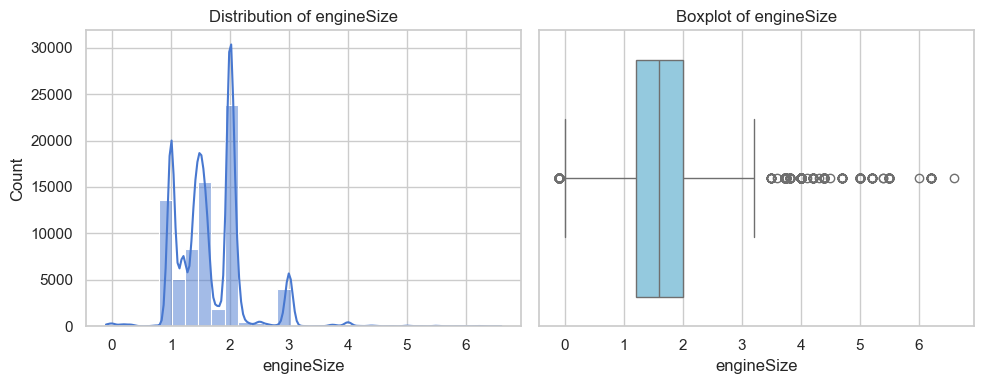

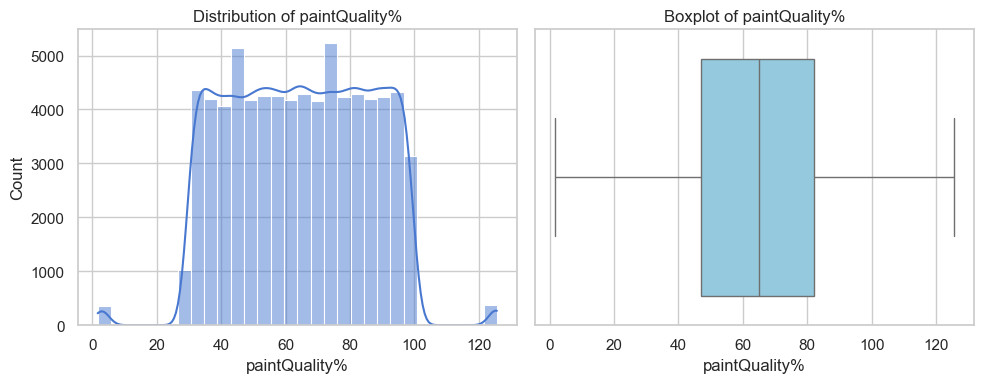

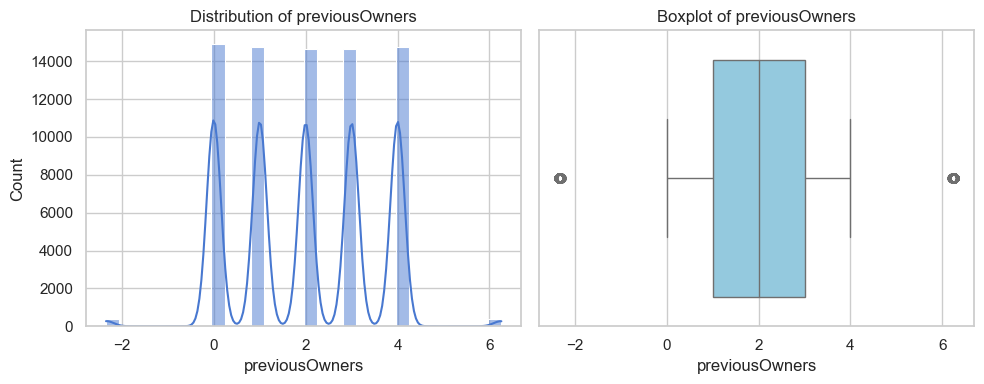

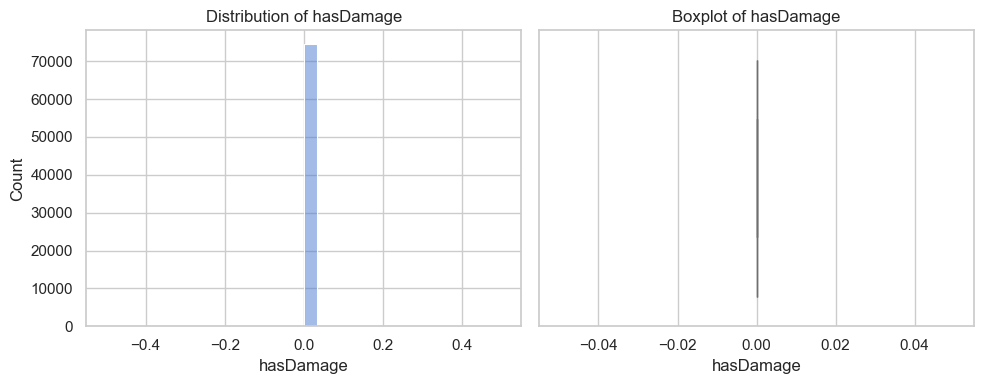


Categorical Feature Distributions


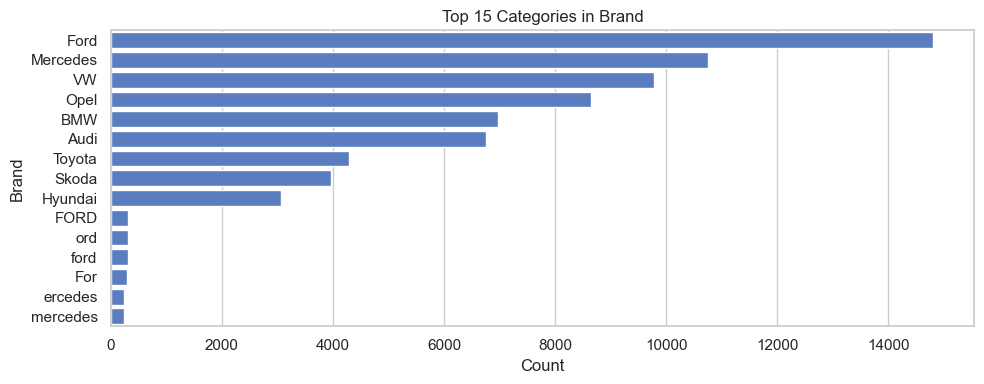

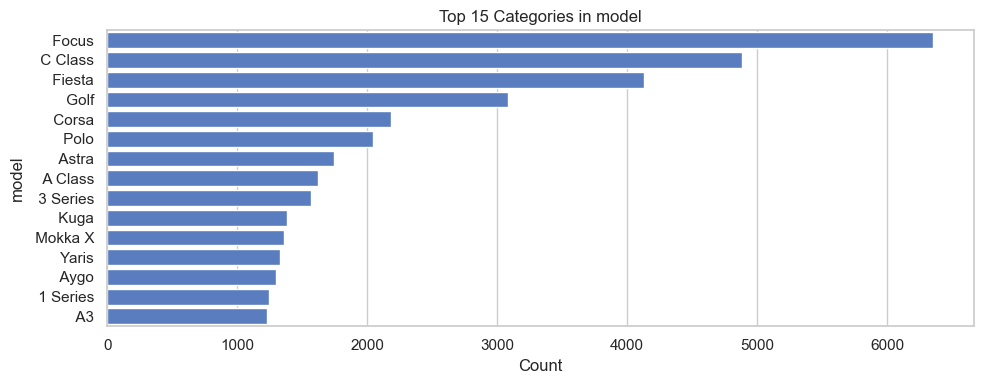

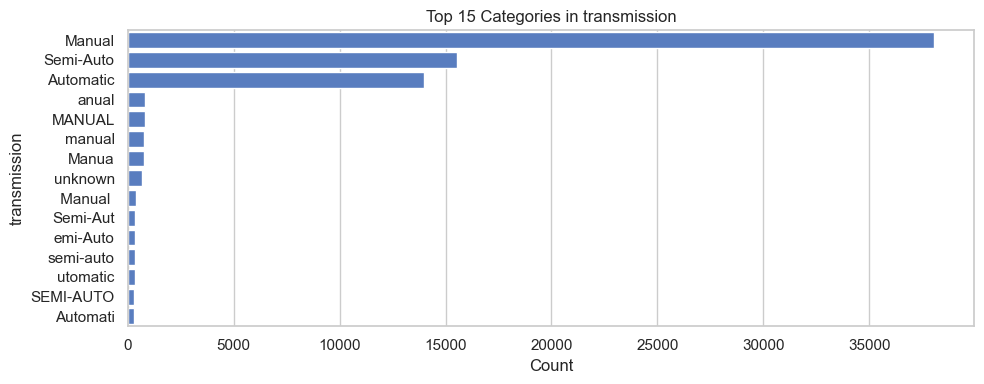

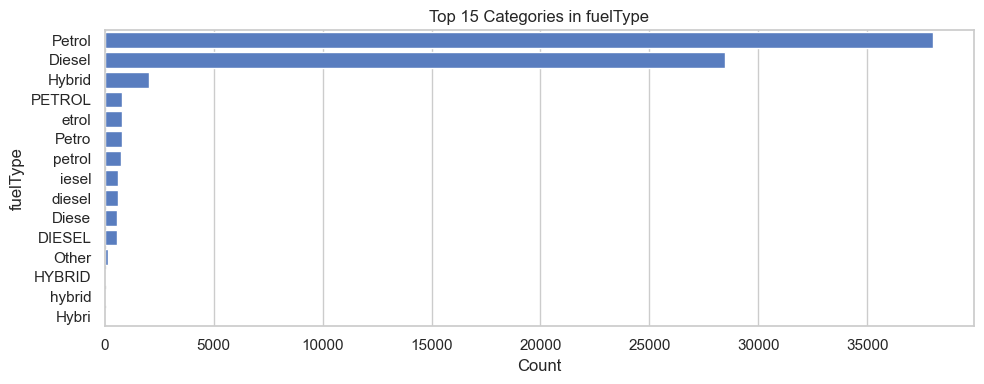

In [11]:
sns.set(style="whitegrid", palette="muted", color_codes=True)

print(f"Numeric columns ({len(num_cols)}): {num_cols}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")

print("\n Numeric Feature Distributions")

for col in num_cols:
    if col == "carID":
        continue
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(cars[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=cars[col], color='skyblue')
    plt.title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

print("\nCategorical Feature Distributions")

for col in cat_cols:
    plt.figure(figsize=(10, 4))
    order = cars[col].value_counts().index[:15]
    sns.countplot(data=cars, y=col, order=order)
    plt.title(f"Top {len(order)} Categories in {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

## Chi-Square of Categorical Columns with price

In [12]:
def TestIndependence(X, y, var, alpha=0.05):        
    dfObserved = pd.crosstab(y, X) 
    chi2, p, dof, expected = chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index=dfObserved.index)
    
    if p < alpha:
        result = f"{var} is IMPORTANT for Prediction"
    else:
        result = f"{var} is NOT an important predictor. (Discard {var} from model)"
    print(result)


target = 'price'

for var in cat_cols:
    TestIndependence(cars[var], cars[target], var)

Brand is NOT an important predictor. (Discard Brand from model)
model is IMPORTANT for Prediction
transmission is IMPORTANT for Prediction
fuelType is NOT an important predictor. (Discard fuelType from model)


## Correlation Heatmap

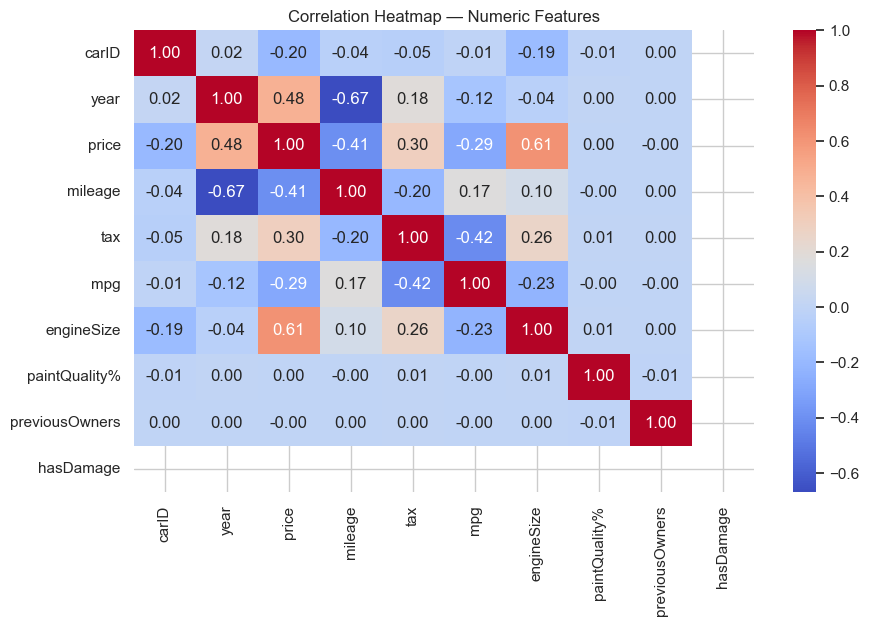

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(cars[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap — Numeric Features")
plt.show()

## Summary Statistics

In [14]:
cars.describe().T

,count,mean,std,min,25%,50%,75%,max
carID,75969.0,37986.478419,21932.101848,0.000000,18992.0,37988.0,56980.0,75972.000000
year,74478.0,2017.096576,2.208750,1970.000000,2016.0,2017.0,2019.0,2024.121759
price,75969.0,16882.001922,9737.075658,450.000000,10200.0,14699.0,20950.0,159999.000000
mileage,74507.0,23004.761128,22130.041696,-58540.574478,7423.5,17301.0,32428.0,323000.000000
tax,68067.0,120.328500,65.522046,-91.121630,125.0,145.0,145.0,580.000000
mpg,68045.0,55.152286,16.497834,-43.421768,46.3,54.3,62.8,470.800000
engineSize,74453.0,1.660161,0.573464,-0.103493,1.2,1.6,2.0,6.600000
paintQuality%,74445.0,64.591773,21.020975,1.638913,47.0,65.0,82.0,125.594308
previousOwners,74419.0,1.994485,1.472961,-2.345650,1.0,2.0,3.0,6.258371
hasDamage,74421.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


## 1. EDA Findings

### Data Issues Summary

After checking the raw data and statistics, we found problems that need to be fixed before we train the model:

#### Data Errors
* Impossible Numbers: Columns like mileage, tax, and previousOwners have negative values, which is impossible. We must correct these.
* Impossible Dates: The year column has dates that are too far in the future. We will fix these years.
* Suspicious Zeros: Some cars show 0 mileage or 0 engine size when they shouldn't.

#### Missing Data
* Many columns, including tax, mpg, and some car details, have missing values (NaN). We need to fill these gaps.

#### Outliers and Skewness
* The price column has extreme high values (outliers) that make it heavily skewed. We need to use a log transformation to fix this.
* Other features are also skewed and have outliers that need to be clipped.

---

### Insights from Visual Charts

We used charts to see the data visually, which helped us find strong relationships.

#### Single Variable Checks
* Price: The chart confirmed the price is pulled up by expensive cars.
* Mileage: Most cars have low mileage, but we need to cut down the extreme high-mileage outliers.

#### Two Variables (Feature vs. Price)
* Mileage vs. Price: The trend is clear: the higher the mileage, the lower the price.
* Year(Age of car) vs. Price: This is a very strong relationship i.e the older the car, the cheaper it is.
* Engine Size vs. Price: Bigger engines usually mean a higher price.

#### All Variables Together (The Color Map)
* Best Predictors: The car's Age and Mileage are the most important numbers for predicting price.

These findings show us exactly how to start the data cleaning and fixing process in the next steps.

# Train - Test split

In [15]:
Y = cars['price']
X = cars.drop(columns=['price', 'carID'])
num_cols_new = X.select_dtypes(include=[np.number]).columns
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42,)

# Data Cleaning

## Numerical Data Cleaning and Minor Fixes

## Cleaning Numerical Features

This part is all about fixing the numbers in the dataset to make sure they're accurate and ready for our model. We are running a cleaning function that handles four main types of errors:

### A. Fixing Impossible Values

1.  **Negative Numbers:** We checked columns like mileage, tax, and engine size. We used a function to fix any negative numbers. We need to do this because you can't have negative distance or negative tax.
2.  **Suspicious Zeros:** We checked for zero values where they don't make sense, like 0 mileage or 0 engine size (if the car isn't electric). We replaced these suspicious zeros with NaN.

### B. Fixing Date and Engine Errors

1.  **Impossible Dates (Year):** We checked the `year` column. We used a function to fix any years that were too far in the future. We turn these into NaN as well.
2.  **Engine Size:** We used a specific function to fix engine size errors. This ensures that very small or negative engine sizes are corrected or turned into missing data.

After these steps, all the bad or impossible numbers are fixed or marked as missing data (NaN), which means we are ready to fill those gaps in the next step.

In [16]:
def fix_negative_values(df, num_cols, target_col='price', threshold=0.7):
    """
    Fix negative values in numerical columns of a DataFrame based on a specified
    threshold and interquartile range (IQR). Handles negative values either by
    converting them to their absolute value or replacing them with NaN, depending
    on their alignment with the distribution of positive values.

    :param df: pandas.DataFrame
        The input dataframe in which numerical columns will be processed.
    :param num_cols: list of str
        A list containing names of numerical columns to process.
    :param target_col: str, optional
        The target column name to exclude from processing. Defaults to 'price'.
    :param threshold: float, optional
        The threshold proportion of in-range negative values (based on IQR) required
        to replace negative values with their absolute values. If the proportion is
        lower than this threshold, negative values are replaced with NaN. Defaults
        to 0.7.
    :return: pandas.DataFrame
        A modified DataFrame where negative values in numerical columns have been
        processed according to the specified rules.
    """
    df = df.copy()
    for col in num_cols:
        if col.lower() == target_col.lower():
            continue
        neg_vals = df.loc[df[col] < 0, col]
        pos_vals = df.loc[df[col] >= 0, col]
        if len(neg_vals) == 0:
            continue
        q1, q3 = pos_vals.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        abs_neg = neg_vals.abs()
        in_range = ((abs_neg >= lower) & (abs_neg <= upper)).mean()
        if in_range > threshold:
            df[col] = df[col].abs()
        else:
            df.loc[df[col] < 0, col] = np.nan
    return df

valid_zero_cols = ['previousOwners', 'hasDamage', 'tax']

def replace_zero_with_nan(df, num_cols):
    """
    Replaces zero values with NaN in specified numeric columns of the DataFrame,
    based on given conditions.

    This function processes the numeric columns to identify zero values and replaces
    them with NaN, while considering specific rules such as a plausible exception
    for electric vehicles (`engineSize` being zero and `fuelType` being electric).
    It ensures to copy the input DataFrame before making modifications.

    :param df: A pandas DataFrame containing the data to process.
    :type df: pandas.DataFrame
    :param num_cols: A list of column names to be processed for replacing zero values.
    :type num_cols: list of str
    :return: A modified DataFrame where zero values are replaced with NaN in the
        specified numeric columns based on the conditions.
    :rtype: pandas.DataFrame
    """
    df = df.copy()
    for col in num_cols:
        if col not in df.columns:
            continue
        if col in valid_zero_cols:
            continue
        if col == 'engineSize' and 'fuelType' in df.columns:
            mask = (df[col] == 0) & (df['fuelType'].str.lower() != 'electric')
        else:
            mask = (df[col] == 0)
        zero_count = mask.sum()
        if zero_count > 0:
            df.loc[mask, col] = np.nan
    return df


def fix_year_values(df):
    """
    Fixes the year values in a DataFrame. This function adjusts the 'year' column in the input DataFrame
    by flooring its values and replacing any year greater than 2020 with NaN.

    :param df: A pandas DataFrame containing a 'year' column. The column values are expected to be
        numeric as the function operates on them to modify and sanitize the data.
    :type df: pandas.DataFrame

    :return: The modified DataFrame with 'year' column values processed. Values greater than 2020 are
        replaced with NaN, and the rest are floored.
    :rtype: pandas.DataFrame
    """
    df['year'] = np.floor(df['year'])
    df.loc[df['year'] > 2020, 'year'] = np.nan
    return df


def fix_engine_size_values(df):
    """
    Fixes the engine size values in the dataframe based on specific conditions.

    This function modifies the 'engineSize' column of the given DataFrame based on
    the following rules:
    - For rows where 'engineSize' is less than 0.6 and the lowercase 'fuelType' is not
      'electric', the 'engineSize' is set to NaN.
    - For rows where 'engineSize' is greater than 0 and the lowercase 'fuelType' is
      'electric', the 'engineSize' is set to 0.

    :param df: The DataFrame containing the columns 'engineSize' and 'fuelType'
               where the conditions for fixing 'engineSize' are to be applied.
    :type df: pandas.DataFrame
    :return: The DataFrame with corrected 'engineSize' values based on the specified
             conditions.
    :rtype: pandas.DataFrame
    """
    df.loc[(df['engineSize'] < 0.6) & (df['fuelType'].str.lower() != 'electric'), 'engineSize'] = np.nan
    df.loc[(df['engineSize'] > 0) & (df['fuelType'].str.lower() == 'electric'), 'engineSize'] = 0
    return df


def apply_numerical_data_cleaning(df, num_cols):
    """
    Apply a series of data cleaning operations to numerical columns in the given DataFrame.

    This function performs a sequence of cleaning operations, specifically
    for numerical data, in order to prepare the dataset for further analysis or processing.
    The steps include fixing negative values, replacing zeros with NaN, addressing
    year-related inconsistencies, and correcting engine size information.

    :param df: The DataFrame containing the data to be cleaned.
               It must include numerical columns specified in 'num_cols'.
    :type df: pandas.DataFrame
    :param num_cols: A list of column names corresponding to the numerical data
                     that will be processed during cleaning.
    :type num_cols: list[str]
    :return: A cleaned version of the DataFrame with adjusted numerical columns.
    :rtype: pandas.DataFrame
    """
    df = fix_negative_values(df, num_cols)
    df = replace_zero_with_nan(df, num_cols)
    df = fix_year_values(df)
    df = fix_engine_size_values(df)
    return df

X_train = apply_numerical_data_cleaning(X_train, num_cols_new)
X_test = apply_numerical_data_cleaning(X_test, num_cols_new)

## Dealing with Categorical Variables

Our objective is to convert non-number columns (like Brand and model) into numbers that the Linear Regression model can use.

### The Steps We Took

1.  **Text Normalization:** We cleaned up the text first. This means converting everything to lowercase and removing extra spaces. This prevents the model from thinking "Manual" is a different category from "manual."

2.  **One-Hot Encoding (OHE):** Since our model is a Linear Regression, we must convert the text columns into many new binary (0 or 1) columns.
    * **How it works:** For the `transmission` column, we created columns like `transmission_manual`, `transmission_automatic`, etc. If a car is manual, the `transmission_manual` column gets a 1, and all others get a 0.
    * **Result:** This process creates many new columns (as seen in the code output), but it lets the model correctly measure the impact of each car brand and feature on the final price.

In [17]:
def normalize_text(df, columns=None):
    """
    Normalize text data in specified columns of a dataframe.

    This function processes textual data in the specified columns of a dataframe by
    making the text lowercase, removing leading/trailing spaces, replacing multiple
    spaces with a single space, removing periods, and standardizing null-like values
    (e.g., 'nan', 'none', 'na', etc.) to the string 'unknown'. If no columns are
    specified, it defaults to all columns with data type 'object'.

    :param df: The input dataframe to normalize.
    :type df: pandas.DataFrame
    :param columns: A list of column names to normalize. If not provided, all
        columns with data type 'object' will be processed.
    :type columns: list or None
    :return: The dataframe with normalized text data in the specified columns.
    :rtype: pandas.DataFrame
    """
    columns = columns or df.select_dtypes(include='object').columns
    for col in columns:
        df[col] = (
            df[col].astype(str)
            .str.lower()
            .str.strip()
            .str.replace(r'\s+', ' ', regex=True)
            .str.replace('.', '', regex=False)
            .replace(['nan', 'none', 'na', 'n/a', '', 'null', 'unknown'], 'unknown')
        )
    return df


def unify_by_substring(df, column):
    """
    Unifies similar strings in a DataFrame column by substituting substring-matching
    values with the most frequent or longest representative.

    The function identifies values in a DataFrame column that are either substrings
    or superstrings of one another (bidirectional matching). For each group of
    matching values, it replaces those values with a representative value. The
    representative is determined by prioritizing the frequency of the value in
    the column; in case of ties, the longest string is chosen.

    :param df: pandas.DataFrame
        The input DataFrame containing the column to process.
    :param column: str
        The name of the column whose values need to be unified.
    :return: pandas.DataFrame
        The updated DataFrame with modified column values.
    """
    unique_vals = df[column].dropna().astype(str).unique().tolist()
    if len(unique_vals) < 2:
        return df
    freq = df[column].value_counts()
    mapping = {}
    used = set()
    for val in unique_vals:
        if val in used:
            continue
        matches = [x for x in unique_vals if (val in x or x in val) and val != x]
        if not matches:
            continue
        matches.append(val)
        used.update(matches)
        rep = max(matches, key=lambda x: (freq.get(x, 0), len(x)))
        for m in matches:
            mapping[m] = rep
    df[column] = df[column].replace(mapping)
    return df



def merge_all_small_categories(df, threshold=0, other_label="other"):
    """
    Merge low-frequency categories into a single category in all object columns of a dataframe.

    This function iterates through all the columns with object dtype in the given dataframe.
    For each column, it finds categories whose frequency is less than a specified threshold
    and replaces those categories with a common label (default is "other"). The function
    operates on a copied version of the original dataframe to ensure the original data remains
    unmodified.

    :param df: pandas DataFrame containing categorical or object columns
    :param threshold: int
        Frequency threshold below which categories are considered rare and merged.
        Default is 0, meaning no merging will occur.
    :param other_label: str
        Label used to replace rare categories. Default is "other".
    :return: pandas DataFrame
        Dataframe with rare categories in all object columns replaced by the specified `other_label`.
    """
    df = df.copy()
    for col in df.select_dtypes(include='object').columns:
        value_counts = df[col].value_counts()
        rare = value_counts[value_counts < threshold].index
        if len(rare) > 0:
            df[col] = df[col].replace(rare, other_label)
    return df


def advanced_auto_clean(df):
    """
    Cleans and standardizes text data in a DataFrame for further processing.
    The function creates a copy of the input DataFrame to ensure the original data remains unaltered and applies
    a series of data cleaning processes, including normalizing text and unifying text substrings. Additionally,
    it handles categorical columns by merging smaller categories into larger groups based on a threshold.

    :param df: pandas DataFrame containing the data to be cleaned. It is expected to contain at least one object
        (string) type column.
    :return: A pandas DataFrame with cleaned and standardized text data.
    :rtype: pandas.DataFrame
    """
    df = df.copy()
    df = normalize_text(df)
    for col in df.select_dtypes(include='object').columns:
        print(f"Cleaning column: {col}")
        df = unify_by_substring(df, col)
        df = merge_all_small_categories(df, threshold=0)
    return df


def summarize_categorical(df, max_values=30):
    """
    Generates a summarized report of categorical data within a DataFrame. This function identifies all
    object-type (categorical) columns in the provided DataFrame and displays a tabulated count of the
    most frequently occurring values in each column up to the specified maximum number of unique values.

    :param df: A pandas DataFrame containing the data to be analyzed.
    :type df: pandas.DataFrame
    :param max_values: Maximum number of distinct values to display per categorical column.
        Defaults to 30.
    :type max_values: int
    :return: None. The function prints the summary directly to the standard output.
    :rtype: None
    """
    for col in df.select_dtypes(include='object').columns:
        counts = df[col].value_counts(dropna=False)
        print(f"\n--- Column: {col} ---")
        print("Top Unique Values and Occurrences:")
        print(counts.head(max_values).to_markdown(numalign="left", stralign="left"))

X_train = advanced_auto_clean(X_train)
X_test = advanced_auto_clean(X_test)
summarize_categorical(X_train)

Cleaning column: Brand
Cleaning column: model
Cleaning column: transmission
Cleaning column: fuelType
Cleaning column: Brand
Cleaning column: model
Cleaning column: transmission
Cleaning column: fuelType

--- Column: Brand ---
Top Unique Values and Occurrences:
| Brand    | count   |
|:---------|:--------|
| ford     | 11239   |
| mercedes | 8203    |
| vw       | 7144    |
| opel     | 6621    |
| bmw      | 5146    |
| audi     | 5106    |
| toyota   | 3240    |
| skoda    | 3001    |
| hyundai  | 2282    |
| unknown  | 1196    |

--- Column: model ---
Top Unique Values and Occurrences:
| model     | count   |
|:----------|:--------|
| focus     | 4859    |
| c class   | 3666    |
| fiesta    | 3129    |
| golf      | 2483    |
| corsa     | 1671    |
| polo      | 1569    |
| mokka x   | 1437    |
| astra     | 1336    |
| a class   | 1216    |
| 3 series  | 1181    |
| e class   | 1140    |
| unknown   | 1055    |
| kuga      | 1051    |
| aygo      | 1000    |
| yaris     | 990   

## Handling Missing Values

We had lots of missing spots (NaNs) in both our number columns and our text (categorical) columns. We handled them with different techniques:

### A. Filling Missing Number Columns

* Action: We used the median to fill all missing spots in our number columns (like mileage, tax, etc.).
* Why Median: The median (the middle number) is safer than the average because it doesn't get messed up by the extreme outliers we found.

### B. Filling Missing Text Columns

* Problem: For categories like Brand or model, just filling with "Ford" (the most common) might be wrong. If a missing car is an expensive sports car, it shouldn't be tagged as "Ford."
* Action: We used a special grouping method to make a better guess.
    * For example, if a car is missing its model name, we look at its Brand, engineSize, and year (its "dependency group") to find the most common model among similar cars and fill it in with that.
* Action (Step 2: Final Fill): If, even after the smart guessing, a few spots are still missing, we then fill the very last remaining gaps with the most frequent category (the overall mode).
* Why: This method makes a much more accurate and logical guess for the missing text data, which keeps our model strong.

In [18]:
categorical_groups = {
    'Brand': ['model'],
    'model': ['Brand', 'engineSize', 'year', 'fuelType'],
    'transmission': ['model', 'engineSize', 'year', 'fuelType'],
    'fuelType': ['model', 'engineSize', 'year'],
}

def fill_numeric_features(df, num_cols, strategy='median'):
    """
    Fills missing numeric features in the provided DataFrame using the specified
    imputation strategy. It identifies columns with missing values, displays a list
    of those columns sorted by the count of missing values, and imputes the missing
    values accordingly. The function returns the updated DataFrame along with the
    fitted imputer object for further use.

    :param df: A pandas DataFrame that contains the data needing imputation.
    :param num_cols: A list of column names in the DataFrame whose missing values
        need to be imputed.
    :param strategy: A string specifying the imputation strategy to use. Supported
        values are 'mean', 'median', or 'most_frequent'. Defaults to 'median'.

    :return: A tuple consisting of the modified DataFrame where the specified
        numeric columns have missing values filled, and the SimpleImputer object
        that was fitted on the data.
    """
    missing = df[num_cols].isna().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    print("Missing values in numeric columns:\n")
    display(missing.to_frame("Missing Count"))
    imputer = SimpleImputer(strategy=strategy)
    df[num_cols] = imputer.fit_transform(df[num_cols])
    return df, imputer


def fill_unknown_categories_from_training(df):
    """
    Fills unknown categories in a given DataFrame using information from its training set.

    This function processes the input DataFrame to clean and impute missing or unknown
    categorical values. Specifically, it converts all string entries to lowercase, 
    removes leading and trailing whitespaces, and replaces occurrences of the string 
    'unknown' with NaN. Grouping-based imputation is performed for specific categorical
    columns as defined by `categorical_groups`. Any remaining missing values in the 
    categorical columns are imputed using the most-frequent strategy.

    :param df: Input DataFrame to be cleaned and imputed.
    :type df: pandas.DataFrame

    :return: A tuple containing the processed DataFrame and the fitted SimpleImputer 
             for categorical columns.
    :rtype: tuple[pandas.DataFrame, sklearn.impute.SimpleImputer]
    """
    df = df.copy()
    df = df.apply(lambda x: x.str.lower().str.strip() if x.dtype == "object" else x)
    df = df.replace('unknown', np.nan)
    for col, deps in categorical_groups.items():
        if col not in df.columns:
            continue
        df[col] = df.groupby(deps, dropna=False)[col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
        )
    cat_cols = list(categorical_groups.keys())
    cat_imputer = SimpleImputer(strategy="most_frequent")
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    for col in cat_cols:
        unknown_final = (df[col] == 'unknown').sum()
        nan_final = df[col].isna().sum()
        print(f"{col}: Unknown: {unknown_final}, NaN: {nan_final}")
    return df, cat_imputer

def fill_unknown_categories_test(df, cat_imputer):
    """
    Fills unknown categories within a given DataFrame by transforming categorical data into a consistent
    lowercase, stripped format, replacing unknown values with NaN, and subsequently imputing based on 
    mode and external imputers.

    :param df: The DataFrame where categorical data needs to be handled.
    :type df: pandas.DataFrame
    :param cat_imputer: An imputer object for handling categorical values in the DataFrame. It is assumed 
        the imputer's `transform` method can process the passed DataFrame columns.
    :type cat_imputer: object
    :return: A copy of the original DataFrame with appropriately cleaned and imputed categorical data.
    :rtype: pandas.DataFrame
    """
    df = df.copy()
    df = df.apply(lambda x: x.str.lower().str.strip() if x.dtype == "object" else x)
    df = df.replace('unknown', np.nan)
    for col, deps in categorical_groups.items():
        if col not in df.columns:
            continue
        df[col] = df.groupby(deps, dropna=False)[col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
        )
    cat_cols = [c for c in categorical_groups.keys() if c in df.columns]
    df[cat_cols] = cat_imputer.transform(df[cat_cols])
    return df


def fill_missing_values(df):
    """
    Fills missing values in a given DataFrame by handling both numeric and
    categorical features. For numeric features, an imputer is utilized to fill
    the missing values, while categorical features are replaced with placeholder
    values for unknown categories.

    :param df: The input pandas DataFrame with potential missing values that
        need to be filled.
    :type df: pandas.DataFrame
    :return: A tuple containing the transformed DataFrame with missing values
        filled, the categorical imputer, and the numeric imputer used for
        preprocessing.
    :rtype: tuple[pandas.DataFrame, any, any]
    """
    df, num_imputer = fill_numeric_features(df, num_cols_new)
    df = fill_unknown_categories(df)
    return df, cat_imputer, num_imputer

X_train, num_imputer = fill_numeric_features(X_train, num_cols_new)
X_train, cat_imputer = fill_unknown_categories_from_training(X_train)

X_test[num_cols_new] = num_imputer.transform(X_test[num_cols_new])
X_test = fill_unknown_categories_test(X_test, cat_imputer)


Missing values in numeric columns:



,Missing Count
tax,5769
mpg,5578
engineSize,1425
year,1289
paintQuality%,1092
hasDamage,1075
previousOwners,1065
mileage,1028


/var/folders/0m/kwht59kj2pv9381k74_52z800000gn/T/ipykernel_3973/770228416.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
/var/folders/0m/kwht59kj2pv9381k74_52z800000gn/T/ipykernel_3973/770228416.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
/var/folders/0m/kwht59kj2pv9381k74_52z800000gn/T/ipykernel_3973/770228416.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprec

Brand: Unknown: 0, NaN: 0
model: Unknown: 0, NaN: 0
transmission: Unknown: 0, NaN: 0
fuelType: Unknown: 0, NaN: 0


/var/folders/0m/kwht59kj2pv9381k74_52z800000gn/T/ipykernel_3973/770228416.py:92: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)


### Missing Values Check

In [19]:
for col in categorical_groups.keys():
    remaining = X_train[col].isna().sum() + (X_train[col] == 'unknown').sum()
    print(f"Training Data -- {col}: {remaining}")
    remaining = X_test[col].isna().sum() + (X_test[col] == 'unknown').sum()
    print(f"Test Data -- {col}: {remaining}")

Training Data -- Brand: 0
Test Data -- Brand: 0
Training Data -- model: 0
Test Data -- model: 0
Training Data -- transmission: 0
Test Data -- transmission: 0
Training Data -- fuelType: 0
Test Data -- fuelType: 0


In [20]:
missing = X_train[num_cols_new].isna().sum().sort_values(ascending=False)
print("Missing values in Train numeric columns after imputation:\n")
display(missing.to_frame("Missing Train Count"))

missing = X_test[num_cols_new].isna().sum().sort_values(ascending=False)
print("Missing values in Test numeric columns after imputation:\n")
display(missing.to_frame("Missing Test Count"))

Missing values in Train numeric columns after imputation:



,Missing Train Count
year,0
mileage,0
tax,0
mpg,0
engineSize,0
paintQuality%,0
previousOwners,0
hasDamage,0


Missing values in Test numeric columns after imputation:



,Missing Test Count
year,0
mileage,0
tax,0
mpg,0
engineSize,0
paintQuality%,0
previousOwners,0
hasDamage,0


### Final Numerical Data Check

In [21]:
for col in num_cols_new:
    neg_vals = cars.loc[cars[col] < 0, col]
    pos_vals = cars.loc[cars[col] >= 0, col]

    if len(neg_vals) == 0:
        print(f"{col}: no negative values in this column")
        continue
    else:
        print(f"{col}: Negative values found in this column, Total negative values found {len(neg_vals)}")

year: no negative values in this column
mileage: Negative values found in this column, Total negative values found 369
tax: Negative values found in this column, Total negative values found 378
mpg: Negative values found in this column, Total negative values found 36
engineSize: Negative values found in this column, Total negative values found 84
paintQuality%: no negative values in this column
previousOwners: Negative values found in this column, Total negative values found 371
hasDamage: no negative values in this column


## Categorical Features Encoding

In [22]:
cat_cols = X_train.select_dtypes(exclude=['number']).columns.tolist()
oe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_train = oe.fit_transform(X_train[cat_cols])
encoded_test = oe.transform(X_test[cat_cols])
encoded_cols = oe.get_feature_names_out(cat_cols)
encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_cols, index=X_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_cols, index=X_test.index)
X_train = pd.concat([X_train.drop(columns=cat_cols), encoded_train_df], axis=1)
X_test = pd.concat([X_test.drop(columns=cat_cols), encoded_test_df], axis=1)

## Statiscal Shape after filling missing values

In [23]:
X_train[num_cols_new].describe()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,53178.000000,53178.000000,53178.000000,53178.000000,53178.000000,53178.000000,53178.000000,53178.0
mean,2017.060551,23310.538705,124.053346,55.091907,1.669304,64.670141,2.013212,0.0
std,2.142326,21464.132706,61.530183,15.626453,0.554940,20.785519,1.427107,0.0
min,1997.000000,1.000000,0.000000,1.100000,0.000000,1.638913,0.000000,0.0
25%,2016.000000,7730.500000,125.000000,47.100000,1.300000,47.000000,1.000000,0.0
50%,2017.000000,17499.500000,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,2019.000000,32383.000000,145.000000,61.400000,2.000000,82.000000,3.000000,0.0
max,2020.000000,323000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


## Feature Engineering

This part is all about creating brand new columns that combine the information from the original raw data. These new features are better predictors of a used car's value than the raw numbers alone.

### What We Made and Why

1.  Car's Age: We calculated the car's age by subtracting the car's year from the current year.
    * Why: A car's age is a much clearer way to see how much its value has dropped (depreciation) compared to just the year it was built.

2.  Mileage Per Year: We calculated the total mileage divided by the car's age.
    * Why: This tells the model how hard the car was used each year. A high 'mileage per year' means the car was driven a lot, which usually lowers the price.

3.  Efficiency Ratio: We created a complex ratio using mpg (gas mileage) and engineSize, and then used a log transformation.
    * Why: This is a way to calculate the car's overall fuel efficiency in a single number. Efficient cars are valued differently than very inefficient, high-performance cars.

These new features will give our model much stronger signals to predict the car prices!

In [24]:
def add_features(df):
    """
    Adds new features to the dataframe for further analysis.

    This function creates additional columns in the given dataframe by modifying
    and calculating relevant properties from the existing columns. It calculates
    age of the vehicle, mileage per year, and an efficiency ratio based on the
    fuel consumption and engine size.

    :param df: A pandas DataFrame containing vehicle data including columns such as
               'year', 'mileage', 'mpg', and 'engineSize'.
    :type df: pandas.DataFrame
    :return: A modified copy of the original DataFrame with added features such as
             'age', 'mileage_per_year', and 'efficiency_ratio'.
    :rtype: pandas.DataFrame
    """
    df = df.copy()
    current_year = datetime.now().year + 1
    df['age'] = current_year - df['year']
    df['mileage_per_year'] = df['mileage'] / (df['age'] + 1)
    df['efficiency_ratio'] = np.log1p(df['mpg'] / (df['engineSize'] + 1))
    return df

X_train = add_features(X_train)
X_test = add_features(X_test)

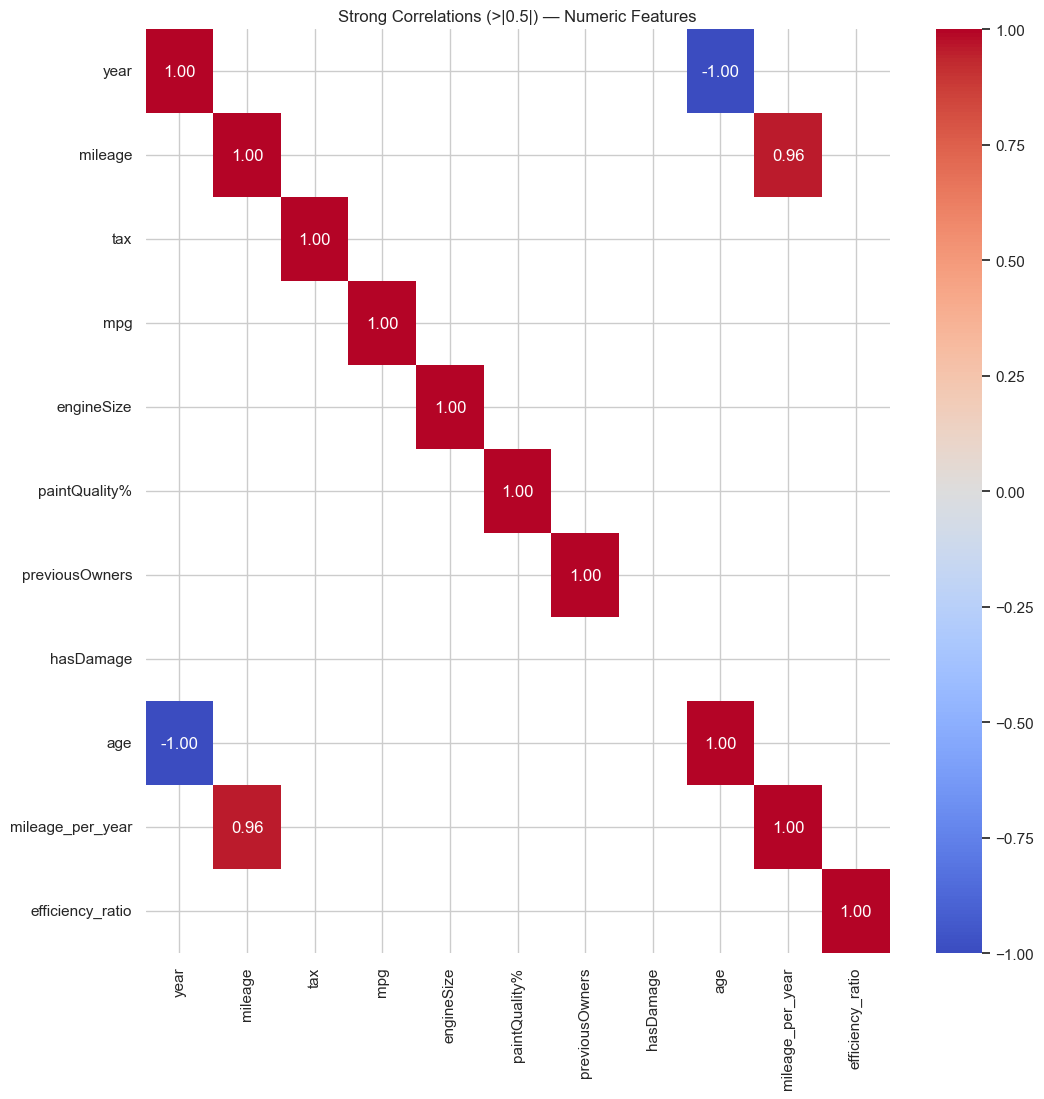

In [25]:
num_cols_new = num_cols_new.to_list()
num_cols_new.extend(['age', 'mileage_per_year', 'efficiency_ratio'])
corr_matrix = X_train[num_cols_new].corr()
strong_corr = corr_matrix[(corr_matrix > 0.75) | (corr_matrix < -0.75)]
plt.figure(figsize=(12, 12))
sns.heatmap(strong_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Strong Correlations (>|0.5|) — Numeric Features")
plt.show()

## Log Transformation of the Target Feature i.e Price

In [26]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

## Feature Dropping

This is a small but important cleanup step we take right after creating our new features.

### Action Taken

* We used a function to remove two original columns from the dataset: year and mileage.

### Why We Dropped Them

* The Problem: We created new, better features like Car's Age (which uses year) and Mileage Per Year (which uses mileage).
* The Confusion: If we keep both the old columns (year and mileage) and the new ones (age and mileage_per_year), our Linear Regression model gets confused. It sees two columns saying almost the same thing.
* The Fix: We drop the original columns (year and mileage) because the new, engineered features (age and mileage_per_year) are more useful for predicting the price.

In [27]:
def drop_highly_correlated_features(df):
    """
    Drops highly correlated features from the given DataFrame. This function attempts to
    remove columns that are deemed highly correlated, such as 'year' and 'mileage', if
    they exist in the DataFrame. If these columns are not present, the operation continues
    without raising an error.

    :param df: The input DataFrame from which highly correlated features need to be
        dropped.
    :type df: pandas.DataFrame
    :return: A DataFrame with the highly correlated features removed, based on the
        specified column names.
    :rtype: pandas.DataFrame
    """
    df = df.drop(columns=['year', 'mileage'], errors='ignore')
    return df
X_train = drop_highly_correlated_features(X_train)
X_test = drop_highly_correlated_features(X_test)

In [28]:
num_cols_new.remove('year')
num_cols_new.remove('mileage')

# Outlier Detection

In [29]:
def detect_outliers(df, col):
    """
    Detects outliers in a specified column of a DataFrame using the Interquartile Range (IQR) method.
    It calculates the lower and upper bounds based on the 1.5 times the IQR and identifies the
    rows that fall outside of these bounds as outliers.

    :param df: pandas DataFrame
        The DataFrame containing the data to analyze.
    :param col: str
        The name of the column in the DataFrame to check for outliers.
    :return: tuple[int, float]
        A tuple containing two values:
        - The number of outliers detected.
        - The percentage of outliers relative to the total rows in the DataFrame.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return len(outliers), round((len(outliers) / len(df)) * 100, 2)

summary = [(col, *detect_outliers(X_train, col)) for col in num_cols_new]
outlier_df = pd.DataFrame(summary, columns=["Column", "Outlier Count", "Percent"])
print(outlier_df)

             Column  Outlier Count  Percent
0               tax          13949    26.23
1               mpg           1203     2.26
2        engineSize            475     0.89
3     paintQuality%              0     0.00
4    previousOwners            251     0.47
5         hasDamage              0     0.00
6               age           1193     2.24
7  mileage_per_year           1552     2.92
8  efficiency_ratio           1719     3.23


In [30]:
X_train[num_cols_new].skew()

tax                 0.028411
mpg                 8.325935
engineSize          1.480831
paintQuality%      -0.015617
previousOwners      0.087659
hasDamage           0.000000
age                 1.832064
mileage_per_year    1.559042
efficiency_ratio   -0.823287
dtype: float64

# Fixing Outliers

Outliers can seriously affect our simple model, so we handled them in two ways:

### Fixing Features with Ourliers

* **Problem:** Some calculated features, like the mileage per year, had extreme outliers showing impossible usage.
* **Action:** We used quantile capping. We cut off the bottom 5% and the top 5% of the most extreme values.
* **Why:** This quickly fixed the worst outliers in the data.

By doing this, we make sure that our model doesn't overreact to those crazy extreme numbers.

## Outlier Clipping

In [31]:
def fit_outlier_caps(df, cols, lower_q=0.05, upper_q=0.95, skew_threshold=1.0):
    """
    Fits outlier caps for specified columns in a DataFrame based on skewness of the data. For columns
    with high skewness, it uses quantile-based capping. For less skewed columns, it employs the
    Interquartile Range (IQR) method. Provides a dictionary mapping each column to its lower and
    upper bounds along with the method used for capping.

    :param df: DataFrame containing the data to be processed
    :type df: pd.DataFrame
    :param cols: List of column names for which outlier caps need to be determined
    :type cols: list[str]
    :param lower_q: Lower quantile threshold used for quantile-based capping (default is 0.05)
    :type lower_q: float
    :param upper_q: Upper quantile threshold used for quantile-based capping (default is 0.95)
    :type upper_q: float
    :param skew_threshold: Absolute skewness threshold to decide which method to apply
                           (default is 1.0)
    :type skew_threshold: float
    :return: Dictionary where keys are column names and values are tuples containing the
             lower bound, upper bound, and the method ('quantile' or 'IQR') used
    :rtype: dict[str, tuple[float, float, str]]
    """
    caps = {}
    for col in cols:
        series = df[col].dropna()
        skew = series.skew()
        if abs(skew) > skew_threshold:
            lower, upper = series.quantile([lower_q, upper_q])
            method = "quantile"
        else:
            q1, q3 = series.quantile([0.25, 0.75])
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            method = "IQR"
        caps[col] = (lower, upper, method)
        print(f"{col}: skew={skew:.2f}, method={method}, lower={lower:.2f}, upper={upper:.2f}")
    return caps


def apply_outlier_caps(df, caps):
    """
    Apply outlier caps to a DataFrame based on specified thresholds.

    This function accepts a DataFrame and a dictionary containing cap limits
    for specific columns. Using the provided limits, it ensures all values
    within the specified columns are clipped to fall within the defined range.
    If a column from `caps` is not present in the DataFrame, it is ignored.

    :param df: pandas.DataFrame
        The input DataFrame for which outlier caps will be applied. A copy of
        the DataFrame is modified instead of altering the original.
    :param caps: dict
        A dictionary where keys are column names corresponding to the DataFrame
        and values are tuples of the form (low, high, _). `low` and `high` are
        the thresholds for the lower and upper bound respectively, while `_`
        is an additional unused value in this tuple.
    :return: pandas.DataFrame
        A DataFrame with outlier values adjusted to meet the defined cap limits.
    """
    df = df.copy()
    for col, (low, high, _) in caps.items():
        if col in df.columns:
            df[col] = df[col].clip(lower=low, upper=high)
    return df

cols_to_cap = ['mileage_per_year', 'efficiency_ratio']
caps = fit_outlier_caps(X_train, cols_to_cap)
X_train = apply_outlier_caps(X_train, caps)
X_test = apply_outlier_caps(X_test, caps)

mileage_per_year: skew=1.56, method=quantile, lower=131.75, upper=5339.77
efficiency_ratio: skew=-0.82, method=IQR, lower=2.33, upper=3.89


## Data Scaling

### Action Taken

* We used the Standard Scaler to adjust all the main numerical features (like mileage, tax, engine size, age, and our calculated features).

### Reasoning

* **The Problem of Different Scales:** Our numerical features are on very different scales. For example, a car's age might be a single digit, but its mileage is in the thousands. In a simple Linear Regression model, the column with the biggest numbers (mileage) would unfairly influence the price prediction just because its values are larger.
* **The Fix:** The Standard Scaler fixes this by transforming all features so they have:
    * An average (mean) of 0.
    * A standard deviation of 1.
* **Why it helps:** This standardization ensures that all features are on a level playing field and contribute fairly to the model. This is a standard and necessary step for Linear Regression to ensure stable and accurate predictions.

In [32]:
def fit_scalers(X_train, numeric_cols):
    """
    Scales the numeric columns of the training dataset using a standard scaler
    and fits the scaler to the provided training data. The scaler is returned
    after fitting for future transformations.

    :param X_train: The input training dataset where numeric columns need to
        be scaled.
    :type X_train: pandas.DataFrame
    :param numeric_cols: A list of column names from `X_train` to be scaled.
    :type numeric_cols: list[str]
    :return: The fitted scaler object after transforming the numeric columns.
    :rtype: sklearn.preprocessing.StandardScaler
    """
    scaler = StandardScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    return scaler

scaler = fit_scalers(X_train, num_cols_new)

X_test[num_cols_new] = scaler.transform(X_test[num_cols_new])

## Feature Selection

### Initial Plan

Our first idea was to use the Correlation Filter. This means we looked at our charts (the color map) and planned to drop some columns that didn't have a strong enough relationship with the car price. The goal was to remove noise and keep the model simple.

### What We Found

* When we actually tried dropping the "unimportant" columns, our prediction error (MAE) actually got worse!
* This showed us that the features we thought were useless were actually helping the model when they were all working together.

### Final Decision

* We decided to remove hasDamage only.
* Why: The most important thing is to have the lowest prediction error. Since the model works best when we give it all the information, we overruled the initial plan and kept the full set of features. Performance wins over simplicity!

In [33]:
corr_scores = X_train.corrwith(y_train).abs().sort_values(ascending=False)
corr_scores

/opt/anaconda3/envs/requirements/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/requirements/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


engineSize                0.622769
efficiency_ratio          0.600560
transmission_manual       0.549445
age                       0.479967
transmission_semi-auto    0.420545
                            ...   
fuelType_electric         0.000720
model_passat              0.000614
fuelType_other            0.000309
transmission_other        0.000050
hasDamage                      NaN
Length: 151, dtype: float64

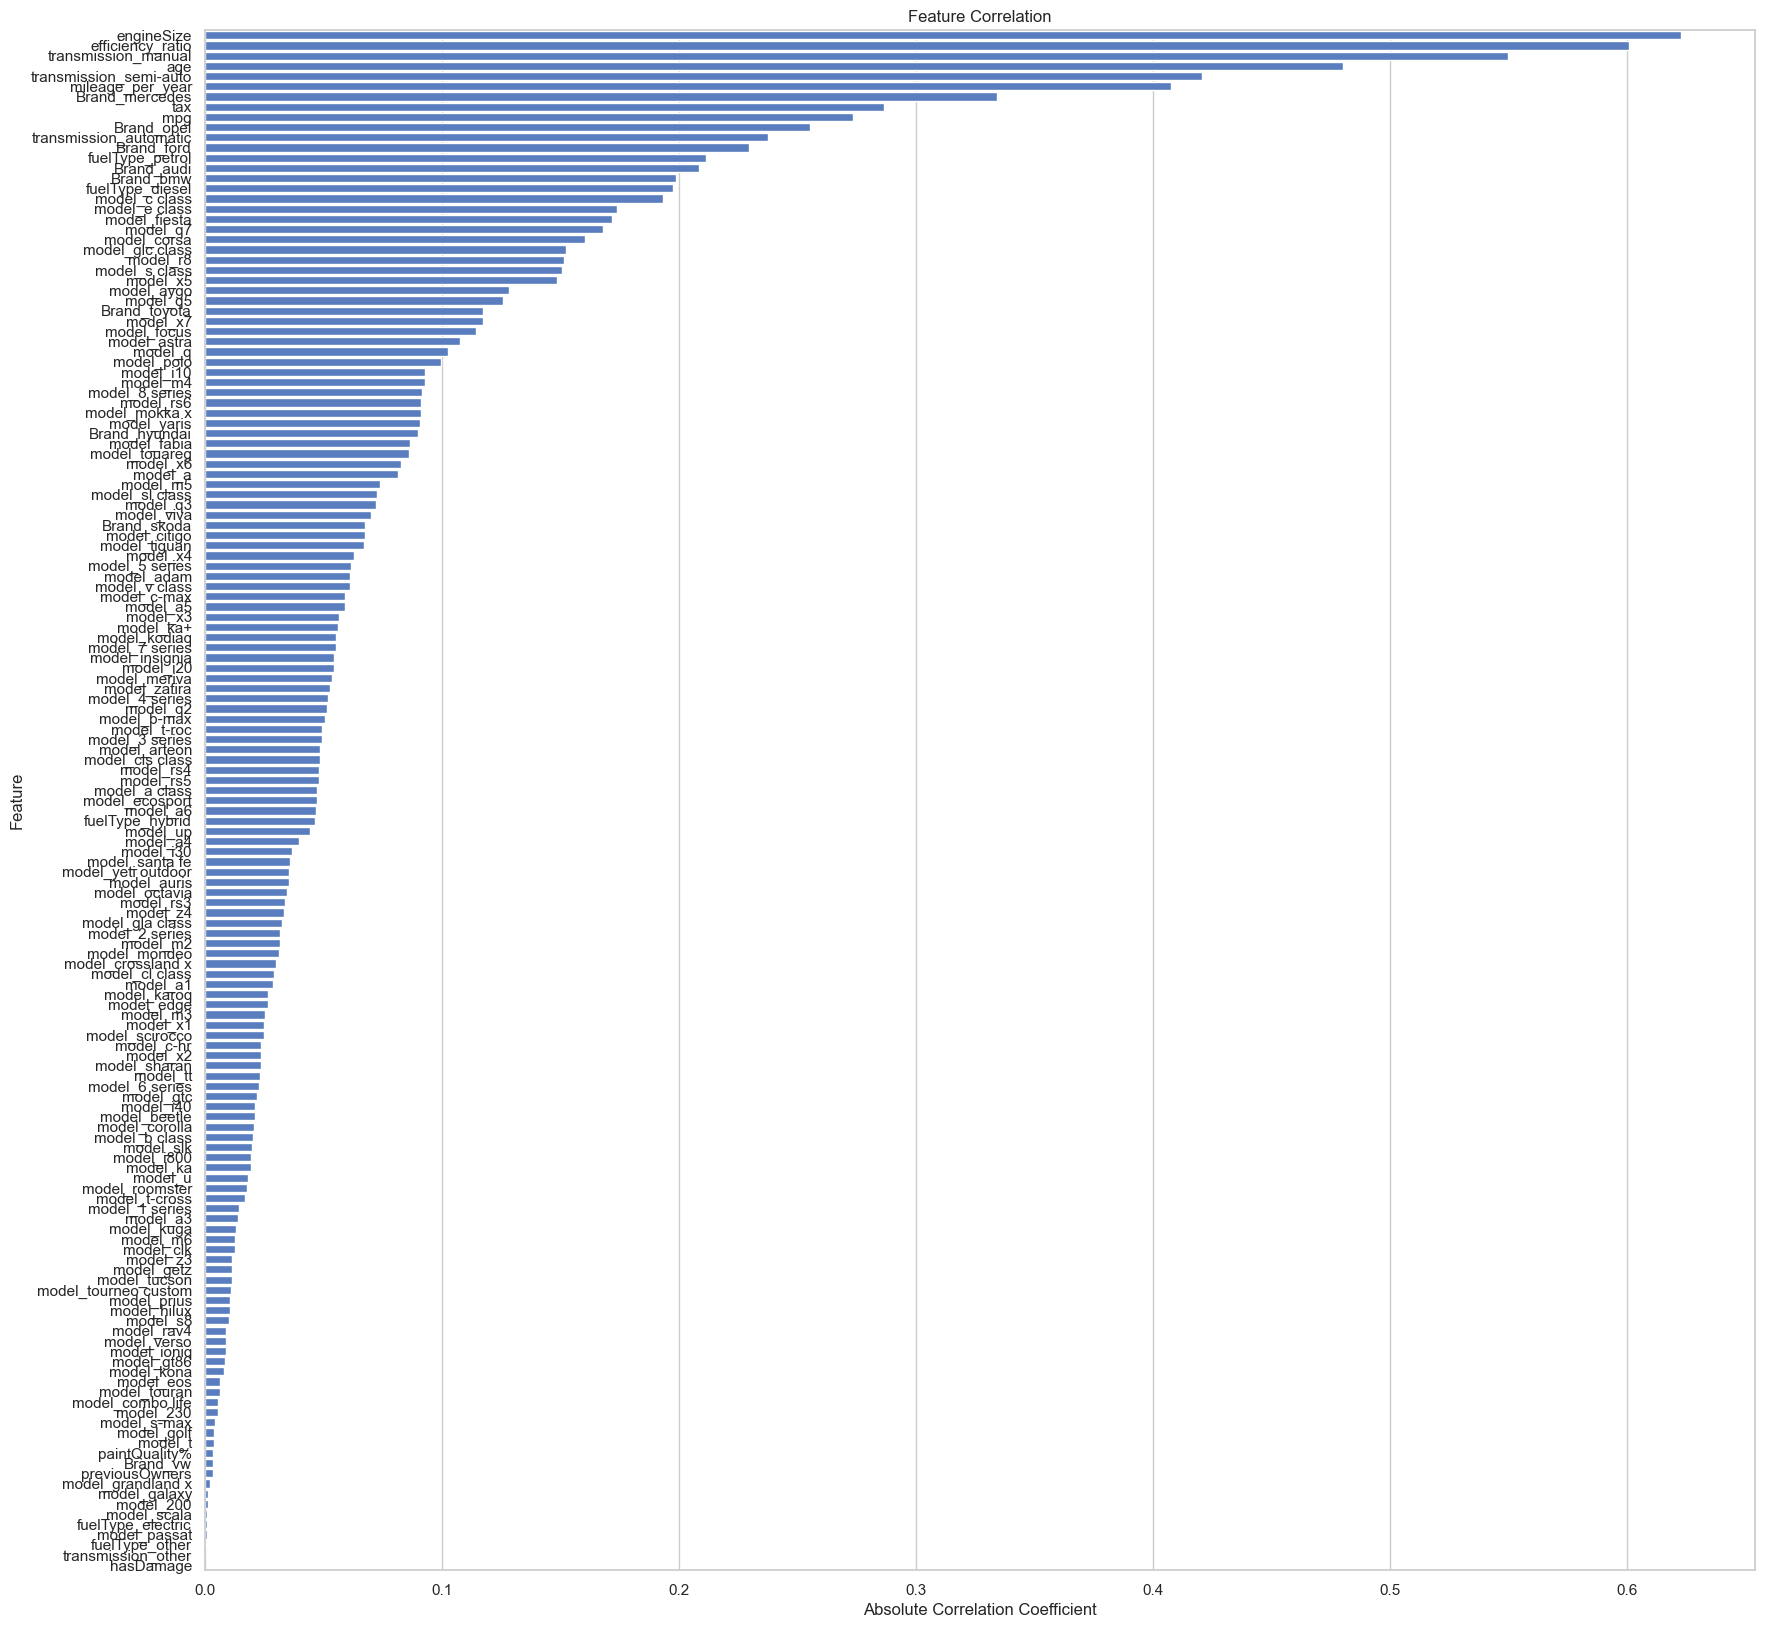

In [34]:
plt.figure(figsize=(20, 20))
sns.barplot(x=corr_scores, y=corr_scores.index)
plt.title("Feature Correlation")
plt.xlabel("Absolute Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

## Model and Checking Performance

### 4.1 Problem Type and Model Choice

* Problem Type: This is a Regression problem.
    * Why: We're trying to predict a continuous number (the car price), not a category.

* Model Choice: We chose Linear Regression as our first model.
    * Why: It's the simplest, most basic model. It gives us a necessary starting point to see how well we can predict the price using a straightforward method.

### 4.2 Assessment Strategy and Metrics

* Assessment Strategy: We used a Train-Test Split.
    * How: We split our data into a Training Set to teach the model (70% of the data) and a Test Set to check its final performance on cars it has never seen (30% of the data).

* Metrics (How We Measure Success): We used one main metrics:

    1. Mean Absolute Error (MAE):
        * Why: This is the most important number because it tells us, on average, exactly how far off our predicted price is from the actual price, in pounds.

In [35]:
top_features = corr_scores.index.tolist()
top_features.remove('hasDamage')
X_train_n = X_train[top_features]
X_test_n = X_test[top_features]

model = LinearRegression()
model.fit(X_train_n, y_train_log)

y_pred_log = model.predict(X_test_n)
y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test, y_pred)
print("\nLINEAR REGRESSION RESULTS")
print(f"MAE      : {mae:.2f}")



LINEAR REGRESSION RESULTS
MAE      : 2030.22


In [36]:
y_train_pred = model.predict(X_train[top_features])
y_test_pred = model.predict(X_test[top_features])

mae_train = mean_absolute_error(y_train, np.expm1(y_train_pred))
mae_test = mean_absolute_error(y_test, np.expm1(y_test_pred))

print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Difference: {mae_test - mae_train:.2f}")

Train MAE: 1936.98
Test MAE: 2030.22
Difference: 93.24


# Visual Comparison

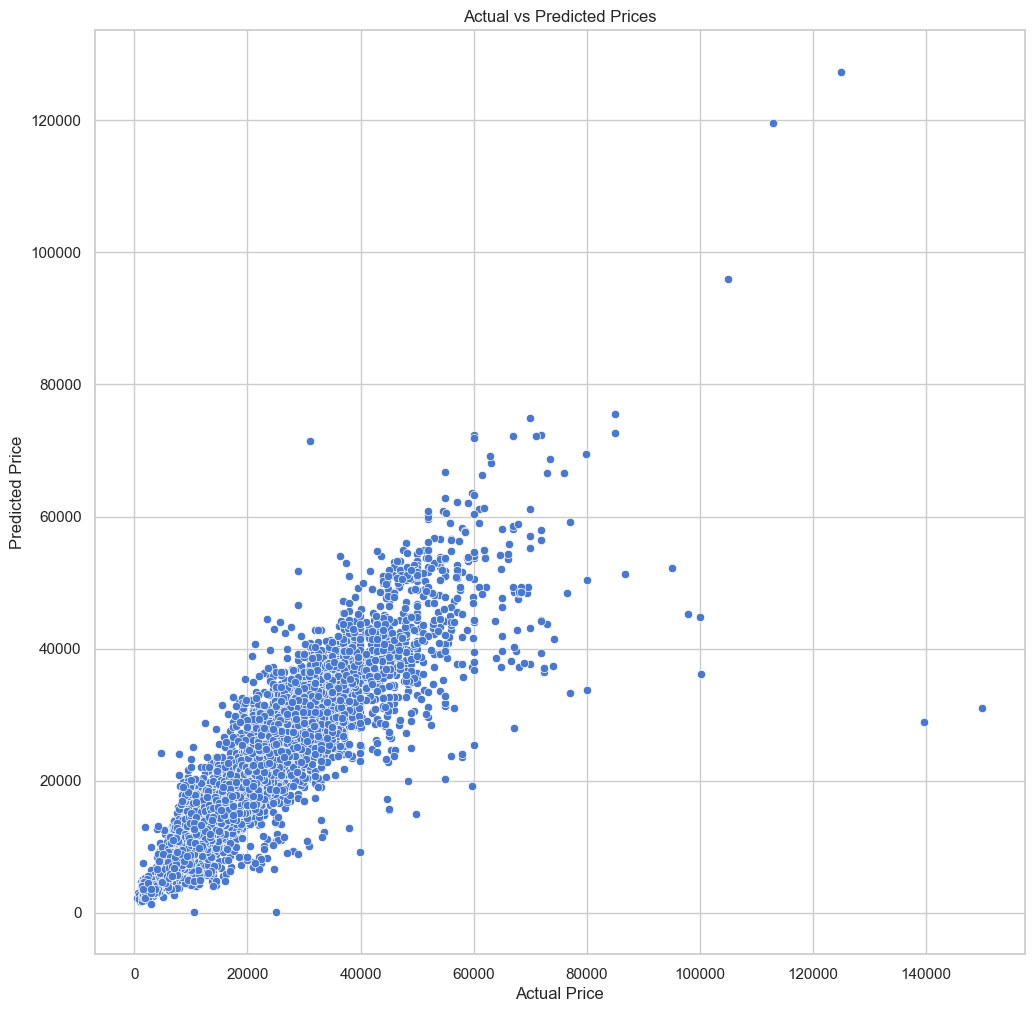

In [37]:
plt.figure(figsize=(12,12))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()

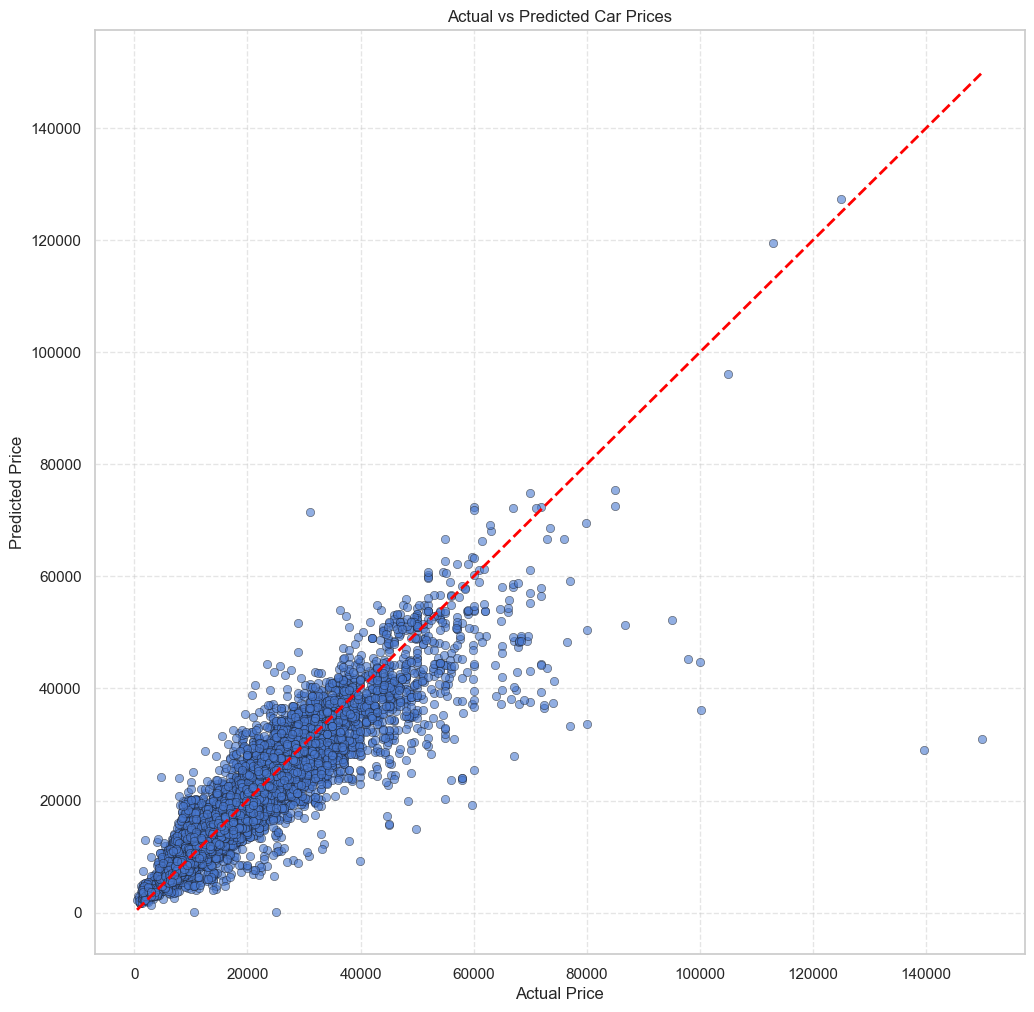

In [38]:
plt.figure(figsize=(12, 12))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [39]:
# Calculate percentage difference
pct_diff = np.abs(y_pred - y_test) / y_test
total = len(y_test)
for tol in [0.05, 0.10, 0.20, 0.30]:
    correct = (pct_diff <= tol).sum()
    print(f"Within {tol*100:.0f}%: {correct}/{total} ({correct/total:.2%})")

Within 5%: 6878/22791 (30.18%)
Within 10%: 12608/22791 (55.32%)
Within 20%: 19273/22791 (84.56%)
Within 30%: 21396/22791 (93.88%)


In [40]:
test_df = pd.read_csv("project_data/test.csv")

num_cols_raw = test_df.select_dtypes(include=[np.number]).columns

test_df = apply_numerical_data_cleaning(test_df, num_cols_raw)
test_df = advanced_auto_clean(test_df)

num_cols = num_cols_raw.drop('carID')
num_cols_for_imputer = [col for col in num_cols_new if col in test_df.columns]
test_df[num_cols] = num_imputer.transform(test_df[num_cols])
test_df = fill_unknown_categories_test(test_df, cat_imputer)

cat_cols = test_df.select_dtypes(exclude=['number']).columns.tolist()
encoded_test = oe.transform(test_df[cat_cols])
encoded_cols = oe.get_feature_names_out(cat_cols)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_cols, index=test_df.index)
test_df = pd.concat([test_df.drop(columns=cat_cols), encoded_test_df], axis=1)

test_df = add_features(test_df)

test_df = drop_highly_correlated_features(test_df)

caps = fit_outlier_caps(test_df, cols_to_cap)
test_df = apply_outlier_caps(test_df, caps)
test_df[num_cols_new] = scaler.transform(test_df[num_cols_new])

y_pred_log = model.predict(test_df[top_features])
y_pred = np.expm1(y_pred_log)

id_col = "carID" if "carID" in test_df.columns else "car_ID"
submission = pd.DataFrame({
    id_col: test_df[id_col].astype(int),
    "price": y_pred
})

submission.to_csv("submission.csv", index=False)
submission.head()

Cleaning column: Brand
Cleaning column: model
Cleaning column: transmission
Cleaning column: fuelType


/var/folders/0m/kwht59kj2pv9381k74_52z800000gn/T/ipykernel_3973/770228416.py:92: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
/var/folders/0m/kwht59kj2pv9381k74_52z800000gn/T/ipykernel_3973/770228416.py:92: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)


mileage_per_year: skew=1.51, method=quantile, lower=125.00, upper=5357.07
efficiency_ratio: skew=-0.74, method=IQR, lower=2.33, upper=3.89


/var/folders/0m/kwht59kj2pv9381k74_52z800000gn/T/ipykernel_3973/770228416.py:92: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)


,carID,price
0,89856,11871.581108
1,106581,18376.238610
2,80886,13066.078769
3,100174,18160.558895
4,81376,23196.345736
